## Build a simple portfolio risk application 

### Description
1. building an grid-like Dash app with the dgrid_components.py module
2. using various techniques to graph data

### Usage
1. Run all of the cells
2. The last cell that executes ```app.run_server``` will display a link to a local URL.  Click on the URL to see the application
3. In the app, click on div **CLICK TO UPLOAD A LOCAL CSV** to upload another csv portolio file of securites that have yahoo market data.  The csv file must have 2 columns:
 * a column named **```symbol```** which has a symbol name like SPY, AAPL, XLK, etc
 * a column named **```position```** which has an integer quantity like 100, or 3333

In [1]:
from IPython.display import display
import dash
import sys,os
if  not os.path.abspath('./') in sys.path:
    sys.path.append(os.path.abspath('./'))
if  not os.path.abspath('../') in sys.path:
    sys.path.append(os.path.abspath('../'))
import display_utilities as du

import datetime
import pandas as pd
from scipy.signal import argrelextrema
import pandas_datareader as pdr
import numpy as np
import importlib
from scipy.stats import norm

from dashgrid import dgrid_components as dgc
import dash_html_components as html

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import pathlib
SYSTEM_HOME = pathlib.Path.home()
import tqdm
from tqdm import tqdm_notebook

### Define a method that creates plotly line graphs

In [2]:
def plot_pandas(df_in,x_column,num_of_x_ticks=20,bar_plot=False,figsize=(16,10),use_secondary_yaxis=True):
    '''
    '''
    df_cl = df_in.copy()
    df_cl.index = list(range(len(df_cl)))
    df_cl = df_cl.drop_duplicates()
    xs = list(df_cl[x_column])
    df_cl[x_column] = df_cl[x_column].apply(lambda i:str(i))

    x = list(range(len(df_cl)))
    n = len(x)
    s = num_of_x_ticks
    x_indices = x[::n//s][::-1]
    x_labels = [str(t) for t in list(df_cl.iloc[x_indices][x_column])]
    ycols = list(filter(lambda c: c!=x_column,df_cl.columns.values))
    all_cols = [x_column] + ycols
    if bar_plot:
        if len(ycols)>1:
            if use_secondary_yaxis:
                ax = df_cl[ycols].plot.bar(secondary_y=ycols[1:],figsize=figsize)
            else:
                ax = df_cl[ycols].plot.bar(figsize=figsize)
        else:
            ax = df_cl[ycols].plot.bar(figsize=figsize)
    else:
        if len(ycols)>1:
            if use_secondary_yaxis:
                ax = df_cl[ycols].plot(secondary_y=ycols[1:],figsize=figsize)
            else:
                ax = df_cl[ycols].plot(figsize=figsize)
        else:
            ax = df_cl[ycols].plot(figsize=figsize)

    ax.set_xticks(x_indices)
    ax.set_xticklabels(x_labels, rotation='vertical')
    ax.grid()
    ax.figure.set_size_inches(figsize)
    return ax




### Define methods to get stock data from yahoo

In [3]:
def str_to_yyyymmdd(d,sep='-'):
    try:
        dt = datetime.datetime.strptime(str(d)[:10],f'%Y{sep}%m{sep}%d')
    except:
        return None
    s = '%04d%02d%02d' %(dt.year,dt.month,dt.day)
    return int(s)

def str_to_date(d,sep='-'):
    try:
        dt = datetime.datetime.strptime(str(d)[:10],f'%Y{sep}%m{sep}%d')
    except:
        return None
    return dt

def fetch_history(symbol,dt_beg,dt_end):
    df = pdr.DataReader(symbol, 'yahoo', dt_beg, dt_end)
    # move index to date column, sort and recreate index
    df['date'] = df.index
    df = df.sort_values('date')
    df.index = list(range(len(df)))
    # make adj close the close
    df['unadj_close'] = df.Close
    df['Close'] = df['Adj Close']
    df = df.drop(['Adj Close'],axis=1)
    cols = df.columns.values 
    cols_dict = {c:c[0].lower() + c[1:] for c in cols}
    df = df.rename(columns = cols_dict)
    df['trade_date'] = df.date.apply(str_to_yyyymmdd)
    df['year'] = df.date.apply(lambda v: v.year)
    df['month'] = df.date.apply(lambda v: v.month)
    df['day'] = df.date.apply(lambda v: v.day)
    return df


### Define a method obtains risk data for a list of stocks

In [36]:
DAYS_TO_FETCH = 200

def get_local_peaks_and_valleys(df_in,n,col='close'):
    '''
    :param df - Input DataFrame
    :param n - number of data points that surround peak and valley
    :param col - the data column to observe
    '''
    df = df_in.copy()
    # Find local peaks
    df['valley'] = df.iloc[argrelextrema(df[col].values, np.less_equal, order=n)[0]][col]
    df['peak'] = df.iloc[argrelextrema(df[col].values, np.greater_equal, order=n)[0]][col]
    return df
    

def get_risk(df_portfolio,days_to_fetch=DAYS_TO_FETCH,beg_dt = None, end_dt = None,irate=.02,confidence=.99):
    dict_returns = {}
    syms = []
    sizes = []
    var_1_99s = []
    lasts  = []
    stdevs = []
    rolling_range_5 = []
    rolling_range_15 = []
    rolling_range_45 = []
    rolling_range_60 = []
    
    sym_size_list = list(zip(df_portfolio.symbol.values,df_portfolio.position.astype(int)))
    for sym,shares in tqdm_notebook(sym_size_list):
        edt = datetime.datetime.now() if end_dt is None else end_dt
        bdt = edt - datetime.timedelta(days_to_fetch) if beg_dt is None else beg_dt 
        df = fetch_history(sym,bdt,edt)
        df['pct']  = df.close.pct_change()
        df = df.iloc[1:]
        dict_returns[sym] = df.pct.values
        # create std
#         df = df[['trade_date','close']]
        last_close = df.iloc[-1].close
        stdev = df.close.pct_change().std()
        dollar_stdev = stdev * last_close * shares
        var_1_99 = norm.ppf(confidence) * dollar_stdev
        syms.append(sym)
        sizes.append(shares)
        lasts.append(last_close)
        var_1_99s.append(var_1_99)
        stdevs.append(stdev)
        rolling_range_5.append((df.high.rolling(5).max() - df.low.rolling(5).min()).max())
        rolling_range_15.append((df.high.rolling(15).max() - df.low.rolling(15).min()).max())
        rolling_range_45.append((df.high.rolling(45).max() - df.low.rolling(45).min()).max())
        rolling_range_60.append((df.high.rolling(60).max() - df.low.rolling(60).min()).max())
        
    df_risk = pd.DataFrame({'symbol':syms,'var_1_99':var_1_99s,'close':lasts,'shares':sizes,'stdev':stdevs,
                           'rolling_range_5':rolling_range_5,'rolling_range_15':rolling_range_15,
                           'rolling_range_45':rolling_range_45,'rolling_range_60':rolling_range_60})
#     df_risk = pd.DataFrame({'symbol':syms,'var_1_99':var_1_99s,'close':lasts,'shares':sizes,'stdev':stdevs})
    df_risk = df_risk.sort_values('symbol')
    df_returns = pd.DataFrame(dict_returns)
    df_corr = df_returns.corr()#.sort_index()
    security_names = df_corr.columns.values
    df_corr['*underlying'] = security_names
    df_corr = df_corr[['*underlying'] + list(security_names)]
    
    return df_risk,df_corr

### Show an example of fetching yahoo data

In [5]:
end_dt = datetime.datetime.now()
beg_dt = end_dt - datetime.timedelta(DAYS_TO_FETCH)

df = fetch_history('XLB',beg_dt,end_dt)
df

,high,low,open,close,volume,date,unadj_close,trade_date,year,month,day
0,58.110001,57.869999,57.910000,57.403343,3439000.0,2019-06-27,58.009998,20190627,2019,6,27
1,58.580002,58.040001,58.099998,57.888222,5008500.0,2019-06-28,58.500000,20190628,2019,6,28
2,58.959999,58.459999,58.930000,58.333519,5970100.0,2019-07-01,58.950001,20190701,2019,7,1
3,58.950001,58.509998,58.950001,58.274143,6320100.0,2019-07-02,58.889999,20190702,2019,7,2
4,59.189999,58.740002,58.849998,58.571007,2475800.0,2019-07-03,59.189999,20190703,2019,7,3
...,...,...,...,...,...,...,...,...,...,...,...
132,59.830002,59.410000,59.549999,59.459999,15764400.0,2020-01-06,59.459999,20200106,2020,1,6
133,59.799999,59.200001,59.360001,59.389999,20266900.0,2020-01-07,59.389999,20200107,2020,1,7
134,59.840000,59.200001,59.400002,59.599998,8079600.0,2020-01-08,59.599998,20200108,2020,1,8
135,59.930000,59.630001,59.790001,59.820000,3786200.0,2020-01-09,59.820000,20200109,2020,1,9


### Show an example of using the ```get_risk``` method above

In [6]:
DEFAULT_PORTFOLIO_NAME = 'spdrs.csv'
print(norm.ppf(.99))
df_p = pd.read_csv(DEFAULT_PORTFOLIO_NAME)
# stock_tuple_list = [('XLB',100),('XLE',100),('XLK',100),('XLU',100)]
df_risk,df_corr = get_risk(df_p)


2.3263478740408408


### Show the risk data

In [7]:
df_risk

,symbol,var_1_99,close,shares,stdev,rolling_range_5,rolling_range_15,rolling_range_45,rolling_range_60
0,XLB,123.865006,59.580002,100,0.008937,3.720001,4.639999,5.710003,6.829998
1,XLC,121.722672,55.160000,100,0.009486,3.629997,4.090000,5.079998,6.629997
2,XLE,169.234108,59.810001,100,0.012163,5.539997,8.100002,9.160000,9.160000
3,XLF,69.817893,30.690001,100,0.009779,2.180000,2.799999,3.809999,4.590000
4,XLI,179.885445,82.750000,100,0.009344,5.820000,7.020004,9.470001,9.989998
5,XLK,233.636364,94.349998,100,0.010644,7.480003,7.639999,11.680000,15.010002
6,XLP,98.728292,62.660000,100,0.006773,3.650002,3.670002,4.570000,4.570000
7,XLU,96.828647,64.400002,100,0.006463,2.889999,3.899998,6.420002,6.420002
8,XLV,185.071861,102.800003,100,0.007739,4.139999,6.480003,12.860001,16.040001
9,XLY,249.379824,126.339996,100,0.008485,8.390007,10.510002,10.970001,10.970001


### Show the correlation data

In [8]:
df_corr

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
XLB,1.000000,0.664020,0.546559,0.737435,0.796885,0.709510,0.549274,0.141524,0.661997,0.714579
XLC,0.664020,1.000000,0.572633,0.771609,0.728897,0.837797,0.539184,0.244337,0.728860,0.817058
XLE,0.546559,0.572633,1.000000,0.698922,0.706087,0.554789,0.256161,0.007115,0.496338,0.546936
XLF,0.737435,0.771609,0.698922,1.000000,0.854174,0.768026,0.506612,0.140727,0.687488,0.813859
XLI,0.796885,0.728897,0.706087,0.854174,1.000000,0.776628,0.458787,0.055127,0.648428,0.796068
XLK,0.709510,0.837797,0.554789,0.768026,0.776628,1.000000,0.582301,0.249877,0.737937,0.850065
XLP,0.549274,0.539184,0.256161,0.506612,0.458787,0.582301,1.000000,0.632235,0.579589,0.616620
XLU,0.141524,0.244337,0.007115,0.140727,0.055127,0.249877,0.632235,1.000000,0.395868,0.252494
XLV,0.661997,0.728860,0.496338,0.687488,0.648428,0.737937,0.579589,0.395868,1.000000,0.664662
XLY,0.714579,0.817058,0.546936,0.813859,0.796068,0.850065,0.616620,0.252494,0.664662,1.000000


### Do an example portfolio VaR calculation

In [9]:
dfv = df_risk[['symbol','var_1_99']]
dfc = df_corr.copy()
port_variance = dfv.var_1_99.astype(float).values.T @ dfc.astype(float).values @ dfv.var_1_99.astype(float).values
port_var = port_variance**.5
port_var

1244.4494141989348

## Show some graphs of price data

### Create ```df_p_v```, a pandas DataFrame that has, n day max to min values, as well as n day peaks and valleys

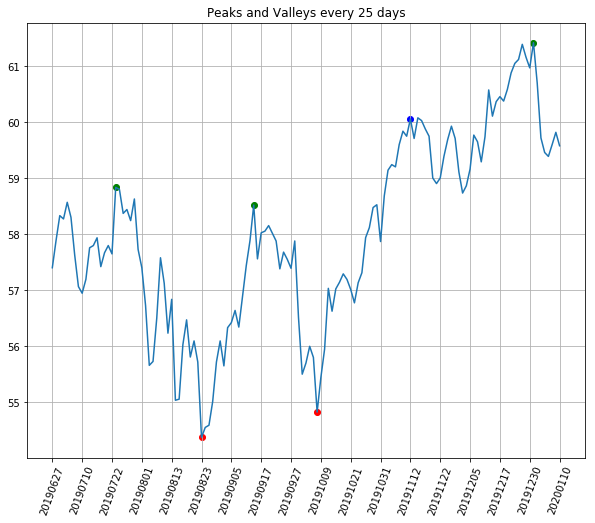

In [10]:
number_of_rolling_days=25

df_p_v = get_local_peaks_and_valleys(df,number_of_rolling_days)
df_p_v['max_min'] = df.high.rolling(number_of_rolling_days).max() - df.low.rolling(number_of_rolling_days).min()
max_range = df_p_v.max_min.max()
df_p_v['is_max_min'] = df_p_v.apply(lambda r: r.close if r.max_min==max_range else np.NaN,axis=1)
df_p_v['is_max_range_point'] = df_p_v.max_min.apply(lambda v: True if v==max_range else False)
fig, ax = plt.subplots(figsize=(10,8))
# plt.figure(figsize=(10,8))
ax.scatter(df_p_v.index, df_p_v['valley'], c='r',label='valley')
ax.scatter(df_p_v.index, df_p_v['peak'], c='g')
ax.scatter(df_p_v.index,df_p_v.is_max_min,c='b')
ax.plot(df_p_v.index, df_p_v['close'])
def format_func(value, tick_number):
    return df_p_v.iloc[tick_number].trade_date
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=70)
newticks = [int(x) if x not in df_p_v.index.values else df_p_v.iloc[int(x)].trade_date for x in ax.get_xticks().tolist()]
ax.set_xticklabels(newticks)
plt.title(f'Peaks and Valleys every {number_of_rolling_days} days')
plt.grid()
plt.show()


### Recreate the graph above with more detail using Matplotlib

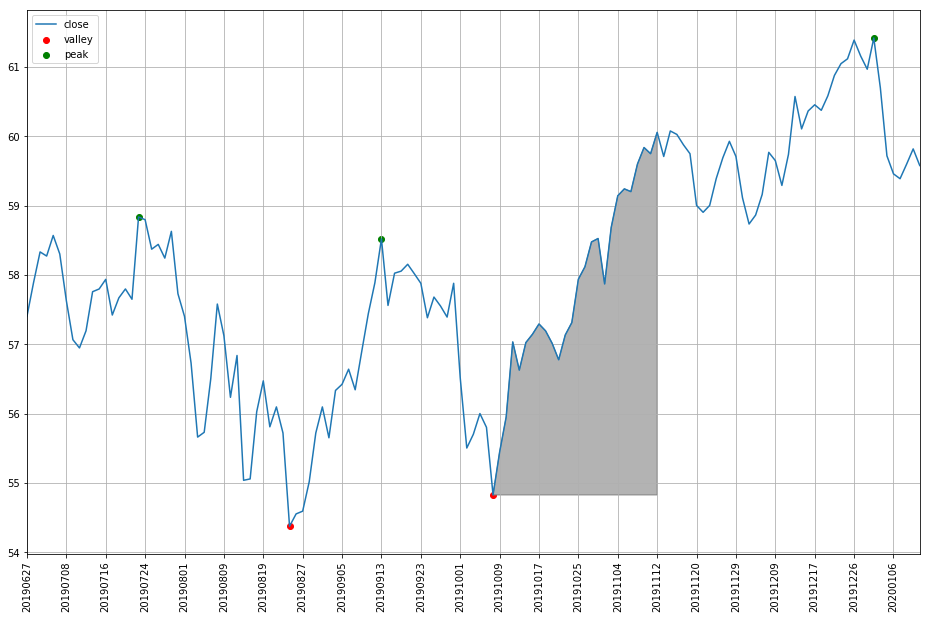

In [11]:
axx = plot_pandas(df_p_v[['trade_date','close']],x_column='trade_date')
index_of_max_range_point = df_p_v[df_p_v.is_max_range_point].index.values[0]
a = 0 if (index_of_max_range_point - number_of_rolling_days)<0 else index_of_max_range_point - number_of_rolling_days
b = index_of_max_range_point 
if (index_of_max_range_point) > len(df_p_v)-1:
    b =  len(df_p_v)-1

Ix = list(range(a,b+1))
Iy = df_p_v.iloc[a:b+1].close.values
verts = [(a,Iy.min())] + list(zip(Ix,Iy)) + [(b,Iy.min())]
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
axx.scatter(df_p_v.index, df_p_v['valley'], c='r',label='valley')
axx.scatter(df_p_v.index, df_p_v['peak'], c='g',label='peak')
axx.add_patch(poly)
axx.legend()
plt.show()

### ### Recreate the graph above with more detail using Plotly
To use plotly, you must assemble a set of plotly go.Figure objects.
They are as follows:
1. sc_main: this is the ```go.Figure``` object that get's returned inside of a tuple, from ```du.plotly_pandas```. 
2. sc1: this is a scatter plot of the ```peak``` column in ```df_p_v```
3. sc2: this is a scatter plot of the ```valley``` column in ```df_p_v```
4. sc3: this is a scatter of just those x and y values during the time period that had the largest n day range
5. sc4: this is a vertical line along the y value that is the min y value of the period that had the largest n day range.  You need this line in order to draw the shaded region, using ```fill=tonexty``` 

In [47]:
axx = du.plotly_pandas(df_p_v[['trade_date','close']],x_column='trade_date',plot_title=f'largest {number_of_rolling_days} day move')
sc_main = axx.data[0]
m1=dict(color='Red',size=10)
m2=dict(color='Blue',size=10)
sc1 = go.Scatter(x=df_p_v.trade_date, y=df_p_v['valley'],mode='markers', marker=m1,name='peaks')
sc2 = go.Scatter(x=df_p_v.trade_date, y=df_p_v['peak'],mode='markers', marker=m2,name='valleys')
min_y = df_p_v.iloc[Ix].close.min()
sc3 = go.Scatter(
    x=df_p_v.iloc[Ix].trade_date,
    y=df_p_v.iloc[Ix].close,
    mode='lines',
    name='y for shaded'
)
sc4 = go.Scatter(
    x=df_p_v.iloc[Ix].trade_date,
    y=[min_y for _ in Iy],
    fill='tonexty',
    fillcolor ='#d3d3d3',
    mode='lines',
    name='low for shaded'
)
data = [sc_main,sc1,sc2,sc3,sc4]
axx2 = go.Figure(data=data,layout=axx.layout)
# iplot(axx)
iplot(axx2)

## Now we will create a Dash Web App to display this info, and graph it

### Create a logger

In [13]:
# a logger is always helpful
logger = dgc.init_root_logger('logfile.log','INFO') 

### Row 1: title div
1. Create a Dash Markdown component, because it is easier to complicated text using Markdown
2. Define a css style
3. Create a Dash html div that holds the markdown, using that style

In [37]:
# This Markdown component allows you to use markdown in html divs
# create row 1
top_markdown = dgc.dcc.Markdown('''
                    # Dash Portfolio Risk Analysis
                    [(Click for Quick Start at page bottom)](#general_help) &nbsp; &nbsp; &nbsp; [(Click for github code to project)](https://github.com/bgithub1/risktables.git)

                    '''
                    ,style={'color':'white'})
# you need to define some css styles as well
STYLE_TITLE={
    'line-height': '20px',
    'textAlign': 'center',
    'background-color':'#47bacc',
    'color':'#FFFFF9',
    'vertical-align':'middle',
} 

top_div = html.Div([top_markdown],style=STYLE_TITLE,id='top_div')


### Row 2 column 1: an Upload button

In [38]:
# create row 2, which has an upload component, and shows the name that of the csv file that was uploaded
yellow_style=dgc.blue_button_style.copy()
yellow_style['background-color'] = '#f2d472'

df_init = pd.read_csv(DEFAULT_PORTFOLIO_NAME)    
u1_comp = dgc.UploadComponent('u1',
            "CLICK TO UPLOAD A LOCAL CSV",
            initial_data=df_init.to_dict('rows'),
            style=yellow_style,
            logger=logger)


### Row 2 column 2: a div that reacts to the upload button and  that displays the uploaded filename

In [39]:
h1_comp = dgc.UploadFileNameDiv('h1',u1_comp,style=yellow_style)

### Row 3 column 1: a DashTable that show the uploaded portfolio

In [40]:
# create row 3, which has a table of the portfolio, and a graph of 1/99 VaR's for each stock
# create row 3 column 1: the first column has a table with the portfolio
dt1_comp = dgc.DashTableComponent('dt1',df_init,u1_comp,
            title='Main Portfolio',
            editable_columns=['position'],
            logger=logger)


### A hidden row with a Dash "storage" component. 
1. The compont stores jsonified versions of pandas DataFrames
2. Each DataFrame contains risk information that will be used in one of the other display components

In [41]:
#  all of the next components will use a dictionary in a special Dash Component called a Store
#  first build a method takes the portfolio and creates a var and correlation dataframe
def create_risk_data(input_list):
    if len(input_list)<1:
        return None
    dict_df = input_list[0]
    df_portfolio = dgc.make_df(dict_df)
    dr_risk,df_corr = get_risk(df_portfolio)
    ret =  {'df_risk':df_risk.to_dict(),'df_corr':df_corr.to_dict()}
    return ret    

#  build a store here
store_all_risk_dfs_comp = dgc.StoreComponent('store_all_risk_dfs', dt1_comp, 
        create_data_dictionary_from_df_transformer=create_risk_data, logger=logger)


### Row 3 column 2: A graph of the VaR's for each member of the portfolio
1. First you define a callback method that extracts the desired columns from one of the risk dataframes created above.
2. Then you create the actual XyGraphComponent to display the extracted data graphically.

In [42]:
# create row 3 column 2: the second column of row will have a VaR graph
#  You need to define a method that converts a jsonified DataFrame back into a DataFrame
def transform_json_input_to_df(dict_df,key_to_show,columns_to_show=None):
    df = None
    dict_this_risk = None
    if len(dict_df)>0:
        json_df_risk = dict_df[key_to_show]
        df = dgc.make_df(json_df_risk)
        if columns_to_show is not None:
            df = df[columns_to_show]
    return df
    
# create the graph    
gr1_comp = dgc.XyGraphComponent('gr1',store_all_risk_dfs_comp,
            x_column='symbol',
            title='VaR Per Underlying Security',
            marker_color='#7e8ed9',
            transform_input=lambda risk_dict: transform_json_input_to_df(risk_dict,'df_risk',columns_to_show=['symbol','var_1_99']),
            logger=logger)    



### Row 4 column 1: a DashTable that show the other risk information for each member of the portfolio

In [43]:
dt_risk_comp = dgc.DashTableComponent('risk_all',None,store_all_risk_dfs_comp,
                title='Risk by Symbol',
                transform_input=lambda risk_dict: transform_json_input_to_df(risk_dict,'df_risk'),
                logger=logger,columns_to_round=[],digits_to_round=3)


### Row 4 column2: a Dash Table of correlations

In [44]:
dt_corr_comp = dgc.DashTableComponent('corr',None,store_all_risk_dfs_comp,
                title='Correlation Matrix',
                transform_input=lambda risk_dict: transform_json_input_to_df(risk_dict,'df_corr'),
                logger=logger,columns_to_round=[],digits_to_round=3)

### Create the Dash app
1. Assemble all of the Dash components in to a list
2. Create a list of css Grid declarations for each row
3. Create the Dash app

In [45]:
app_component_list = [top_div,u1_comp,h1_comp, store_all_risk_dfs_comp, dt1_comp,gr1_comp,dt_risk_comp,dt_corr_comp] 
# gtcl = ['1fr','49.7% 49.7%','100%',['50% 50%','25% 25% 25% 25%','50% 50%','50% 50%','50% 50%','100%','1fr','100%','50% 50%']]
gtcl = ['1fr','49.7% 49.7%','100%','50% 50%','50% 50%']
app_to_use = dgc.dash.Dash()
app = dgc.make_app(app_component_list,grid_template_columns_list=gtcl,app=app_to_use)    


### Run the app

In [46]:
app.run_server(host='127.0.0.1',port=8500)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


2020-01-13 08:04:44,867 - werkzeug - INFO -  * Running on http://127.0.0.1:8500/ (Press CTRL+C to quit)
2020-01-13 08:04:52,027 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:52] "GET / HTTP/1.1" 200 -
2020-01-13 08:04:52,136 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:52] "GET /_dash-component-suites/dash_renderer/prop-types@15.7.2.min.js?v=1.0.0&m=1574289295 HTTP/1.1" 200 -
2020-01-13 08:04:52,146 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:52] "GET /_dash-component-suites/dash_renderer/react@16.8.6.min.js?v=1.0.0&m=1574289295 HTTP/1.1" 200 -
2020-01-13 08:04:52,152 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:52] "GET /_dash-component-suites/dash_renderer/react-dom@16.8.6.min.js?v=1.0.0&m=1574289295 HTTP/1.1" 200 -
2020-01-13 08:04:52,166 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:52] "GET /_dash-component-suites/dash_core_components/highlight.pack.js?v=1.0.0&m=1574289294 HTTP/1.1" 200 -
2020-01-13 08:04:52,169 - werkzeug - INFO - 127.0.0.1 

2020-01-13 08:04:52,813 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:52] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:04:52,819 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:52] "POST /_dash-update-component HTTP/1.1" 200 -


2020-01-13 08:04:53,179 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:53] "POST /_dash-update-component HTTP/1.1" 204 -


2020-01-13 08:04:58,312 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:58] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:04:58,483 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:58] "POST /_dash-update-component HTTP/1.1" 200 -


2020-01-13 08:04:58,769 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:58] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:04:58,833 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:58] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:04:58,994 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:58] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:04:59,025 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:04:59] "POST /_dash-update-component HTTP/1.1" 200 -


2020-01-13 08:05:47,220 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:05:47] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:05:47,270 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:05:47] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:05:47,287 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:05:47] "POST /_dash-update-component HTTP/1.1" 200 -
2020-01-13 08:05:47,322 - werkzeug - INFO - 127.0.0.1 - - [13/Jan/2020 08:05:47] "POST /_dash-update-component HTTP/1.1" 200 -
